# Preprocess Lightcurve

(1) Select data folder containing .h5 light curves

(2) Select folder where to output binned light curves (stored as .h5)

In [204]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.robust import scale
import collections
import h5py

# From Chelsea
sys.path.append('../Modules')

# From astronet
sys.path.append('../Modules') 
from astronet import median_filter


In [3]:
# Select data folder containing light curves and .blsanal
lcfolder  = "../Data/2020_03_26_TestData/LC/"
blsfolder = "../Data/2020_03_26_TestData/BLS/"

# Select folder where binned lightcurves are saved. Lightcurve names are the same as input
outputfolder = "./"
assert os.path.normpath(outputfolder) != os.path.normpath(lcfolder), "Won't overwrite data files"

# Find all light curve files

# Loop through all files in LC folder
allfiles = os.listdir(lcfolder)
lcfiles  = []
blsfiles = []
nomit    = 0
for lcfile in allfiles:
    
    # construct .blsanal filepath given .h5 filepath
    blsfile = os.path.join(blsfolder,lcfile).replace("h5","blsanal")

    # check LC file has .h5 extension
    # check accompanying BLS file exists
    if (lcfile.split(".")[-1] == "h5" and os.path.exists(blsfile)):
        lcfiles.append(lcfile)
        blsfiles.append(blsfile)
    else:
        nomit += 1
        
nfiles = len(lcfiles)
print("Found {} lightcurves and ommitted {} files".format(nfiles,nomit))

Found 96 lightcurves and ommitted 0 files


- 3 lightcurves, phase folded period = 1, binned, all apertures
- 1 lightcurve, phase folded period = 2, halfperiod = 2, binned, main aperture only

In [188]:
# Bins for single period phase folded
nbins_global = 201
nbins_local  = 61

# Bins for double period phase folded
nbins_double = 402

# Number of apertures
naps  = 3 

# Array that holds all single period lcs
errors   = []

# Loop over each lightcurve
for i in range(nfiles):
    
    # Progress bar
    print("{} / {}\r".format(i,nfiles-1),end="")
    
    try:
        # Input LC from existing .h5
        filepath = os.path.join(lcfolder,lcfiles[i])
        h5inputfile = h5py.File(os.path.join(lcfolder,lcfiles[i]),'r')
        og_time = np.array(h5inputfile["LightCurve"]["BJD"])
        
        # Read in period
        blsanal = np.genfromtxt(blsfiles[i], dtype=float, delimiter=' ', names=True) 
        period  = blsanal['BLS_Period_1_0']
        duration = blsanal["BLS_Qtran_1_0"] * period
        t0 = blsanal["BLS_Tc_1_0"]
        # Output binned LC to new .h5 in different folder
        if os.path.exists(os.path.join(outputfolder,lcfiles[i])):
            os.remove(os.path.join(outputfolder,lcfiles[i]))
        h5outputfile = h5py.File(os.path.join(outputfolder,lcfiles[i]),"w")
        globalviews   = h5outputfile.create_group("GlobalView")
        localviews    = h5outputfile.create_group("LocalView")

        # Check which is best ap
        best_ap = "Aperture_%.3d" % h5inputfile["LightCurve"]["AperturePhotometry"].attrs['bestap']
        h5outputfile.create_dataset("bestap",(1,), data =  int(best_ap[-3:]))

        #####################
        # 1. Single period binned lightcurves, all aps
        #####################
        aps_list = list(h5inputfile["LightCurve"]["AperturePhotometry"].keys())

        for j in range(len(aps_list)):
            # Read in time, KSP magnitude
            all_mag  = np.array(h5inputfile["LightCurve"]["AperturePhotometry"]["Aperture_%.3d" % j]["KSPMagnitude"])
            real_indices = ~np.isnan(all_mag)
            all_mag  = all_mag[real_indices]
            all_time = og_time[real_indices]

            # Remove outliers
            mad           = scale.mad(all_mag)
            valid_indices = np.where(all_mag > np.median(all_mag)-5*mad)
            assert len(valid_indices) <= 1, "Need more data points"
            all_mag       = all_mag[valid_indices]
            all_time      = all_time[valid_indices]

            # Convert mag to flux
            all_flux = 10.**(-(all_mag - np.median(all_mag))/2.5)

            # Phase Fold
            half_period  = period / 2
            folded_time  = np.mod(all_time + (half_period - t0), period) - half_period
            sorted_i     = np.argsort(folded_time)
            folded_time  = folded_time[sorted_i]
            folded_flux  = all_flux[sorted_i]

            ##############
            # Global view
            ##############
            bin_width_global = period * 1.2 / nbins_global
            (tmin_global,tmax_global) = (-period / 2, period / 2)
            view  = median_filter.median_filter(folded_time, folded_flux, nbins_global, \
                                                bin_width_global, tmin_global,tmax_global)

            # Center about zero flux
            view -= np.median(view)

            # Shift bins so bin with minimum flux is centered
            view = collections.deque(view)
            minindex = np.argmin(view)
            view.rotate(100 - minindex) # hardcoded assuming nbins_global = 201
            globalviews.create_dataset(aps_list[j],(nbins_global,),dtype=float, \
                                       data = np.array(view))
            ##############
            # Local view
            ##############
            bin_width_local = duration * 0.16
            tmin_local = max(-period / 2, -2 * duration)
            tmax_local = min(period / 2, 2* duration)

            view  = median_filter.median_filter(folded_time, folded_flux, nbins_local, \
                                                bin_width_local, tmin_local,tmax_local)

            # Center about zero flux
            view -= np.median(view)

            # Shift bins so bin with minimum flux is centered
            view = collections.deque(view)
            minindex = np.argmin(view)
            view.rotate(30 - minindex) # hardcoded assuming nbins_local = 61
            datad = np.array(view)
            localviews.create_dataset(aps_list[j],(nbins_local,), \
                                       data = datad)
            
            
            
        #####################
        # 2. Double period light curve, only best ap
        #####################
#         all_mag  = np.array(h5inputfile["LightCurve"]["AperturePhotometry"][best_ap]["KSPMagnitude"])

#         real_indices = ~np.isnan(all_mag)
#         all_mag  = all_mag[real_indices]
#         all_time = og_time[real_indices]

#         mad           = scale.mad(all_mag)
#         valid_indices = np.where(all_mag > np.median(all_mag)-5*mad)

#         all_mag       = all_mag[valid_indices]
#         all_time      = all_time[valid_indices]

#         # Convert mag to flux
#         all_flux = 10.**(-(all_mag - np.median(all_mag))/2.5)

#         # Phase Fold
#         half_period  = period / 4
#         folded_time  = np.mod(all_time + (half_period), period) - half_period
#         sorted_i     = np.argsort(folded_time)
#         folded_time  = folded_time[sorted_i]
#         folded_flux  = all_flux[sorted_i]

#         # Bin with median values
#         bin_width = 2 * period * 1.2 / nbins
#         (tmin,tmax) = (-period / 2, period / 2)
#         view  = median_filter.median_filter(folded_time, folded_flux, nbins, bin_width, tmin,tmax)

#         # Normalize
#         view -= np.median(view)
# #         view /= np.abs(np.min(view))  # breaks if min(view) is zero...
#         globalviews.create_dataset("Double",(nbins_double,),dtype=float, data = np.array(view))

        h5outputfile.close()
    except:
        print("Could not read in {}".format(filepath))
        errors.append(lcfiles[i])
        h5outputfile.close()
        os.remove(os.path.join(outputfolder,lcfiles[i]))
print("{} errors".format(len(errors)))

0 errors


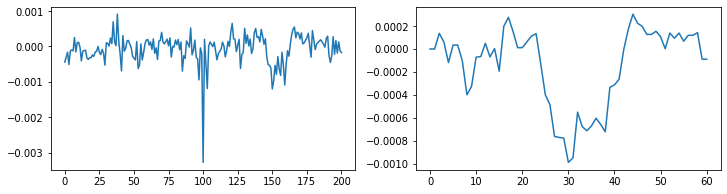

In [203]:
test = h5py.File(os.path.join(outputfolder,lcfiles[59]),'r')

fig,ax = plt.subplots(ncols = 2,figsize=(12,3))
ax[0].plot(test["GlobalView"]["Aperture_%.3d" % test["bestap"][0]])
ax[1].plot(test["LocalView"]["Aperture_%.3d" % test["bestap"][0]])